# Less-Referenced Mosaic Evaluation

This notebook provides a cross-section of the Less-Referenced Mosaic creation process.

# Setup

## Imports

In [1]:
import copy
import os

In [2]:
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.utils import check_random_state
import yaml

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
sns.set_style('white')

In [4]:
from night_horizons import utils, preprocess, reference, mosaic, raster, pipelines, features

## Settings

In [5]:
with open('./config.yml', "r", encoding='UTF-8') as file:
    settings = yaml.load(file, Loader=yaml.FullLoader)

In [6]:
local_settings = {
    'include_raw_images': False,
    'mosaic_filepath': 'mosaics/referenced_test.tiff',
    'random_state': 1682142,
    'train_size': {
        0: 0,
        1: 1,
        2: 0,
    },
    'n_loops': 10,
    'save_bad_images': True,
    'bad_images_dir': '../test/test_data/feature_matching',

    # Choices for how images are combined
    'image_joiners_options': {
        'defaults': {
            'feature_detector': 'AKAZE',
            'feature_matcher': 'BFMatcher',
            'log_keys': ['dst_kp', 'dst_pts', 'src_kp', 'src_pts', 'mask', 'abs_det_M'],
            'debug_mode': True,
        },
        'variations': [
            {'n_matches_used': 100, },
        ],
    },

    # Cuts for movement and altitude
    'gyro_mag_cut': 0.02,
    'percent_for_cruising': 85.,
    
    # Choices for search region
    'padding': 2.,
    'use_approximate_georeferencing': True,
    # This set of choices assumes we have really good starting positions.
    # This is useful for debugging.
    # 'padding': 0.1,
    # 'use_approximate_georeferencing': False,

    # The fraction of non-nan georeferencings required to claim success.
    'acceptance_fraction': 0.95,

    # These values will be logged and checked for consistency.
    'log_keys': ['x_off', 'y_off', 'x_size', 'y_size', 'dst_img', 'dst_kp', 'src_kp', 'abs_det_M', 'return_code'],

}
settings.update(local_settings)

## Parse Settings

In [7]:
settings['mosaic_filepath'] = os.path.join(settings['data_dir'], settings['mosaic_filepath'])

In [8]:
for key, relpath in settings['paths_relative_to_data_dir'].items():
    settings[key] = os.path.join(settings['data_dir'], relpath)

In [9]:
random_state = check_random_state(settings['random_state'])

In [10]:
palette = sns.color_palette(settings['color_palette'])

In [11]:
crs = settings['crs']

In [12]:
constructor_kwargs = dict(
    image_joiner=features.ImageJoinerQueue(**settings['image_joiners_options']),
    filepath=settings['mosaic_filepath'],
    padding=settings['padding'],
    file_exists='overwrite',
    log_keys=settings['log_keys'],
    crs=crs,
    debug_mode=True,
    bad_images_dir=settings['bad_images_dir'],
)

# Prepare Data
The first part is to prepare the data (AKA extract/transform/load).

## Get filepaths

In [13]:
# Get the referenced filepaths, divided according to camera number
referenced_fps = {i: utils.discover_data(settings['referenced_images_dir'], ['tif', 'tiff'], pattern=r'Geo\s\d+_' + f'{i}.tif') for i in range(3)}

In [14]:
raw_fps = utils.discover_data(settings['images_dir'], ['tif', 'tiff', 'raw'])

## Train-Test Split

We split the data into training data (data that is georeferenced) and test data (data that is not georeferenced, or for which we don't use the georeferencing information when we're building the models).

We set the train size to some small number, because ideally the user only needs to georeference a couple of images manually.

In [15]:
# Get the training sample for each camera
referenced_fps_train = []
referenced_fps_test = []
for camera_num, train_size_i in settings['train_size'].items():

    # When there's no training for this camera
    if train_size_i == 0:
        referenced_fps_test.append(referenced_fps[camera_num])
        continue
        
    referenced_fps_train_i, referenced_fps_test_i = train_test_split(
        referenced_fps[camera_num],
        train_size=train_size_i,
        random_state=settings['random_state'],
        shuffle=True,
    )
    referenced_fps_train.append(referenced_fps_train_i)
    referenced_fps_test.append(referenced_fps_test_i)


In [16]:
referenced_fps_train = pd.concat(referenced_fps_train, ignore_index=True)
referenced_fps_test = pd.concat(referenced_fps_test, ignore_index=True)

## Combine Referenced and Raw

In [17]:
# Adjust the index so we don't have duplicates
raw_fps.index += referenced_fps_test.size

In [18]:
# Actual combination
fps_train = referenced_fps_train
fps_test = referenced_fps_test
if settings['include_raw_images']:
    fps = pd.concat([referenced_fps_test, raw_fps])
else:
    fps = referenced_fps_test

## Preprocessing

### y values
We get the y-values first because we use a model fitted to them to get the X values

In [19]:
preprocessing_pipeline_y = preprocess.GeoTIFFPreprocesser(crs=crs)

In [20]:
# Get the geo-transforms used for training
y_train = preprocessing_pipeline_y.fit_transform(fps_train)
y_test = preprocessing_pipeline_y.fit_transform(fps_test)

100%|████████████████████████████████████████| 160/160 [00:00<00:00, 211.28it/s]


### X values
We use the sensor (high-altitude balloon) positions to provide approximate georeferencing, which will be useful for saving computational time when building the unreferenced mosaic.

In [21]:
# This is the pipeline for approximate georeferencing
preprocessing_steps = pipelines.PreprocessingPipelines.nitelite_preprocessing_steps(
    crs=crs,
    use_approximate_georeferencing=settings['use_approximate_georeferencing'],
)
preprocessing_pipeline = Pipeline(preprocessing_steps)
preprocessing_pipeline

Pipeline(steps=[('metadata', NITELitePreprocesser()),
                ('select_deployment_phase', AltitudeFilter(column='mAltitude')),
                ('select_steady',
                 SteadyFilter(columns=['imuGyroX', 'imuGyroY', 'imuGyroZ'])),
                ('georeference',
                 SensorGeoreferencer(passthrough=['filepath', 'camera_num'])),
                ('order', SensorAndDistanceOrder())])

In [22]:
# Fit the pipeline
preprocessing_pipeline = preprocessing_pipeline.fit(
    fps_train,
    y_train,
    metadata__img_log_fp=settings['img_log_fp'],
    metadata__imu_log_fp=settings['imu_log_fp'],
    metadata__gps_log_fp=settings['gps_log_fp'],
)

In [23]:
# Get out the X values we'll use for the mosaic
X_train = preprocessing_pipeline.transform(fps_train)
X = preprocessing_pipeline.transform(fps_test)

/Users/Shared/repos/night-horizons-mapmaker/night_horizons/preprocess.py:152: UserWarning: Did not successfully correlate all filepaths. n_uncorrelated = 2
  warnings.warn(w_message)


In [24]:
# Drop the y values and filepaths that were filtered out
fps = fps.loc[X.index]
y_test = y_test.loc[X.index]

# Build the Mosaic

## Initialization

In [25]:
less_reffed_mosaic = mosaic.LessReferencedMosaic(
    **constructor_kwargs
)

In [26]:
# This creates the dataset and adds the referenced mosaic.
less_reffed_mosaic.fit(
    X=y_train,
    approx_y=X,
)

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.24it/s]


## Run

In [27]:
y_pred = less_reffed_mosaic.predict(
    X.iloc[:settings['n_loops']],
)

100%|███████████████████████████████████████████| 10/10 [00:13<00:00,  1.33s/it]


In [28]:
less_reffed_mosaic.close()

# Evaluate

## Failed Images
How many were there? Where were they?

In [32]:
# Check how many were successful
return_codes = pd.Series(less_reffed_mosaic.log['return_code'])
n_good = (return_codes == 'success').sum()
n_bad = settings['n_loops'] - n_good
assert n_good / settings['n_loops'] > settings['acceptance_fraction'], \
    (
        f"{n_bad} failures, success rate of {settings['acceptance_fraction']} not met. "
        f'Return codes are...\n{return_codes.map(utils.ERROR_CODE_MAP)}'
    )

In [33]:
return_codes

0        success
1        success
2        success
3        success
4        success
5        success
6        success
7        success
8        success
9        success
10    dark_frame
11    dark_frame
12       success
13       success
14       success
15       success
16       success
17       success
18    dark_frame
19    dark_frame
dtype: object

In [34]:
# Merge into a comparison dataframe
y_pred_for_eval = y_pred.reindex(y_test.index)

In [35]:
# Estimate the consistency with the manual geotransforms
y_err = y_test - y_pred_for_eval
err = np.sqrt(y_err['x_min']**2. + y_err['y_max']**2.)

In [36]:
# Check how bad the errors are
n_egregious = (err > 300.).sum()
assert n_egregious == 0, f'Found {n_egregious} egregious errors.'

/Users/Shared/miniconda3/envs/night-horizons/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Shared/miniconda3/envs/night-horizons/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Shared/miniconda3/envs/night-horizons/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


(0.0, 149.15782613904182)

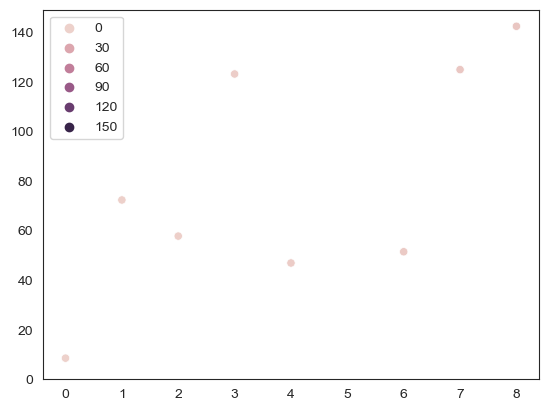

In [37]:
# Visualize the errors
fig = plt.figure()
ax = plt.gca()

sns.scatterplot(
    x=np.arange(y_err.index.size),
    y=err,
    hue=np.arange(len(y_err)),
    ax=ax,
)

ax.set_ylim(0, ax.get_ylim()[1])